## Visualisation graphique pour un portefeuille sélectionné

A partir des statistiques pour tous les portefeuilles, L'on cherche à mettre en évidence les raisons des différences de tracking selon les fonds thématiques sélectionnés. 


In [1]:
from src.models import *
from src.evaluation import *
from src.data_processing import load_returns_data, compose_monthly_returns
import pandas as pd
import numpy as np
import cvxpy as cp
from itertools import product

In [13]:
#1. Chargement et préparation des données

#Chemins des fichiers
thematic_file = "data/raw/msci_acwi_imi_thematics_daily_returns_202007_202508.csv"
sector_file = "data/raw/msci_acwi_imi_sectors_daily_returns_202007_202508.csv"

#Chargement des rendements journaliers des fonds thématiques et secteurs
thematic_df_daily = load_returns_data(thematic_file)
sector_df_daily = load_returns_data(sector_file)

#Supprimer les colonnes thématiques ayant des valeurs manquantes en début de série
nan_first_idx = thematic_df_daily.drop('date', axis=1).apply(lambda col: col.first_valid_index())
if not thematic_df_daily.empty:
    # Cherche la première date disponible dans la série principale
    debut_date = thematic_df_daily['date'].min()
    drop_cols = [
        col for col in thematic_df_daily.columns if col != 'date'
        and pd.isna(thematic_df_daily.loc[thematic_df_daily['date'] == debut_date, col]).any()
    ]
    thematic_df_daily = thematic_df_daily.drop(columns=drop_cols)


#Supression de la dernière ligne pour les deux datasets comme ligne incomplète.
thematic_df_daily = thematic_df_daily.iloc[:-1, :]
sector_df_daily = sector_df_daily.iloc[:-1, :]

# Transformation des rendements quotidiens en rendements mensuels
thematic_monthly = compose_monthly_returns(thematic_df_daily)
sector_monthly = compose_monthly_returns(sector_df_daily)


/Users/jeanjacob/Portfolio-replication/src/data_processing.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return ((1 + df).resample('M').prod() - 1).reset_index()
/Users/jeanjacob/Portfolio-replication/src/data_processing.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return ((1 + df).resample('M').prod() - 1).reset_index()


## Premier portefeuille cible : MSCI ACWI IMI Digital Economy Index

In [ ]:
# 2. Paramètres & préparation in sample / out-of-sample
# Portefeuille cible : MSCI ACWI IMI Digital Economy Index
target_col = [col for col in thematic_monthly.columns if col != 'date'][4]
dates = thematic_monthly['date'].values

# Les secteurs, toutes les colonnes hors 'date'
X_full = sector_monthly.drop(columns='date').values
y_full = thematic_monthly[target_col].values

         # regularisation Ridge

# Découpe in-sample / out-of-sample (e.g. 70%/30%)
split_idx = int(0.7 * len(y_full))
X_in, y_in = X_full[:split_idx], y_full[:split_idx]
X_out, y_out = X_full[split_idx:], y_full[split_idx:]
dates_in, dates_out = dates[:split_idx], dates[split_idx:]

# Paramètres pour walk-forward
initial_train_size = len(y_in)   # calibré pour que IS = in-sample
window_size = 12                # taille de la fenêtre glissante (mois)
rebalance_every = 1             # rebalance chaque période 


#3. Exécution des modèles
model_preds_df = pd.DataFrame({'date': dates_out, 'Réalité': y_out})

# Modèle simple: Régression Linéaire Contrainte (entraînement sur tout l'historique, prediction sur tout)
w1 = constrained_linear_regression(X_in, y_in)
yhat1 = X_out @ w1

rmse1 = np.sqrt(np.mean((y_out - yhat1)**2))
model_preds_df['Constrained Linear (Simple)'] = yhat1

# Régression Linéaire Contrainte (walk-forward)
w2, yhat2, rmse2 = walk_forward_rebalancing_sliding_window(
    X_full, y_full, initial_train_size, window_size, rebalance_every
)
model_preds_df['Constrained Linear'] = yhat2

# Régression Ridge Contrainte

#D'abord, on cherche le coefficient alpha optimal: 
alpha_range = np.logspace(-3, 1, 20)  # De 0.001 à 10, 20 valeurs logarithmiques
optimal_alpha = find_optimal_ridge_alpha(
    X_full, y_full,
    split_idx,
    window_size,
    alpha_range,
    validation_split=0.2
)

# Puis on applique le modèle Ridge avec l'alpha optimal:
w3, yhat3, rmse3 = walk_forward_ridge_rebalancing_sliding_window(
    X_full, y_full, initial_train_size, window_size, optimal_alpha, rebalance_every
)
model_preds_df['Constrained Ridge'] = yhat3

# Algorithme génétique
window_size = 18
ngen = 50  # Nombre de générations (plus élevé = meilleure solution mais plus lent)
pop_size = 100  # Taille de la population
cxpb = 0.5  # Probabilité de croisement
mutpb = 0.2  # Probabilité de mutation

# Exécuter l'algorithme génétique avec sliding wind

w4, yhat4, rmse4, fitness_history = \
    walk_forward_genetic_tracking(
        X_full, y_full,
        initial_train_size,
        window_size,
        ngen=ngen,
        pop_size=pop_size,
        cxpb=cxpb,
        mutpb=mutpb,
        rebalance_every=1,
        verbose=False
    )

model_preds_df['Genetic Algorithm'] = yhat4

w5, yhat5, rmse5 = \
        walk_forward_mean_variance_tracking(
            X_full, y_full, 
            initial_train_size,
            window_size,
            rebalance_every=1  # Rebalancement mensuel
        )

model_preds_df['Mean Variance Tracking'] = yhat5


recap = pd.DataFrame([
    {
        'Modèle': 'Constrained Linear (Simple)',
        'RMSE Out-of-Sample': rmse1
    },
    {
        'Modèle': 'Constrained Linear (IS/OS)',
        'RMSE Out-of-Sample': rmse2
    },
    {
        'Modèle': 'Constrained Ridge',
        'RMSE Out-of-Sample': rmse3
    },
    {
        'Modèle': 'Genetic Algorithm',
        'RMSE Out-of-Sample': rmse4
    }
])

print("Tableau récapitulatif des performances :")
print(recap)



Alpha = 0.0010: Tracking Error = 1.4403%
Alpha = 0.0016: Tracking Error = 1.4477%
Alpha = 0.0026: Tracking Error = 1.4879%
Alpha = 0.0043: Tracking Error = 1.5494%
Alpha = 0.0070: Tracking Error = 1.6644%
Alpha = 0.0113: Tracking Error = 1.8353%
Alpha = 0.0183: Tracking Error = 2.0636%
Alpha = 0.0298: Tracking Error = 2.3291%
Alpha = 0.0483: Tracking Error = 2.6088%
Alpha = 0.0785: Tracking Error = 2.8698%
Alpha = 0.1274: Tracking Error = 3.1443%
Alpha = 0.2069: Tracking Error = 3.3849%
Alpha = 0.3360: Tracking Error = 3.5685%
Alpha = 0.5456: Tracking Error = 3.6993%
Alpha = 0.8859: Tracking Error = 3.7881%
Alpha = 1.4384: Tracking Error = 3.8463%
Alpha = 2.3357: Tracking Error = 3.8836%
Alpha = 3.7927: Tracking Error = 3.9071%
Alpha = 6.1585: Tracking Error = 3.9219%
Alpha = 10.0000: Tracking Error = 3.9310%
Optimisation avec algorithme génétique (window=18, pop=100, gen=50)...
  Période 1/19


/opt/miniconda3/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/miniconda3/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Période 11/19
✓ Optimisation terminée. Tracking Error: 0.7383%
Tableau récapitulatif des performances :
                        Modèle  RMSE Out-of-Sample
0  Constrained Linear (Simple)            0.007644
1   Constrained Linear (IS/OS)            0.009350
2            Constrained Ridge            0.009089
3            Genetic Algorithm            0.007383


## 1. Comparaison des retours mensuels des stratégies de réplication

Revenus cumulés base 100 (toutes les dates) :
                   date     Réalité  Constrained Linear (Simple)  \
0            2024-01-01  100.000000                   100.000000   
1            2024-01-01  100.000000                   100.000000   
2   2024-01-31 00:00:00  102.457467                   101.932247   
3   2024-02-29 00:00:00  109.248403                   107.960237   
4   2024-03-31 00:00:00  112.361705                   110.612001   
5   2024-04-30 00:00:00  107.661327                   106.418560   
6   2024-05-31 00:00:00  113.548514                   112.442263   
7   2024-06-30 00:00:00  120.594567                   119.008286   
8   2024-07-31 00:00:00  118.821623                   117.014586   
9   2024-08-31 00:00:00  122.203750                   118.734311   
10  2024-09-30 00:00:00  128.200846                   123.783338   
11  2024-10-31 00:00:00  127.966682                   122.361664   
12  2024-11-30 00:00:00  135.777366                   127.660327   
13

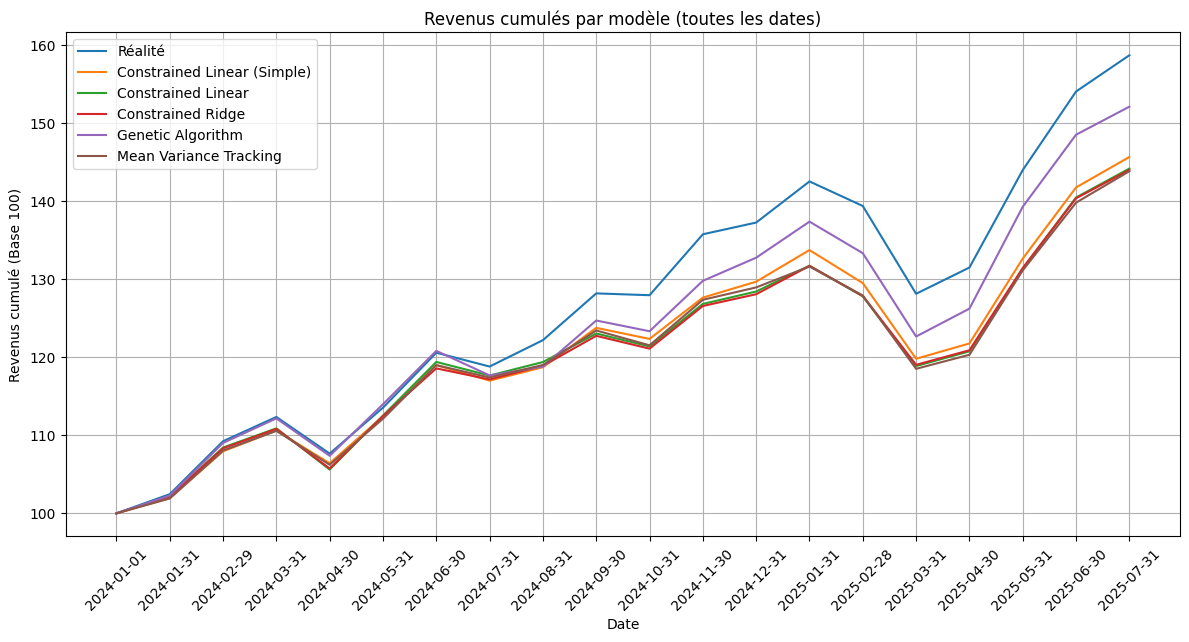

In [18]:
# Crée une nouvelle ligne avec la date '2024-01-01' (format YYYY-MM-DD)
new_row = pd.DataFrame({
    'date': ['2024-01-01'],
})

# Ajoute des colonnes avec les mêmes noms que model_preds_df sauf 'date', avec valeur 0.0
for col in model_preds_df.columns:
    if col != 'date':
        new_row[col] = 0.0

# Place la nouvelle ligne au début et réindexe correctement
model_preds_df = pd.concat([new_row, model_preds_df], ignore_index=True)

# Si la colonne 'date' doit devenir l'index (optionnel, selon structure attendue)
# model_preds_df.set_index('date', inplace=True)

# Calcule les retours cumulés (base 100) pour toutes les séries et toutes les dates

# On suppose que model_preds_df contient au moins la colonne 'date' et des colonnes de rendements mensuels

cumulative_base100_df = model_preds_df.copy()
for col in model_preds_df.columns:
    if col != 'date':
        # Calcule la série de cumul des rendements mensuels, base 100
        cumulative_base100_df[col] = 100 * (1 + model_preds_df[col].astype(float)).cumprod()

# Affiche la dataframe complète des retours cumulés
print("Revenus cumulés base 100 (toutes les dates) :")
print(cumulative_base100_df)

import matplotlib.pyplot as plt

# S'assurer que la colonne 'date' est bien au format AAAA-MM-JJ sans heure/min/sec
date_x = pd.to_datetime(cumulative_base100_df['date']).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(12, 6))
for col in cumulative_base100_df.columns:
    if col != 'date':
        plt.plot(date_x, cumulative_base100_df[col], label=col)

plt.xlabel("Date")
plt.ylabel("Revenus cumulé (Base 100)")
plt.title("Revenus cumulés par modèle (toutes les dates)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Affiche les labels de l'axe x en biais pour voir toutes les dates
plt.show()



## 2. Comparaison des retours journaliers des stratégies de réplication

In [19]:
# Récupérer les noms des secteurs
sector_names = [col for col in sector_df_daily.columns if col != 'date']

# Créer toutes les combinaisons (date, secteur)
combinations = list(product(dates_out, sector_names))

# Créer le dataframe
weights_df = pd.DataFrame(combinations, columns=['date', 'sector'])
weights_df['date'] = pd.to_datetime(weights_df['date'])

# Créer un mapping secteur -> index
sector_to_idx = {sector: idx for idx, sector in enumerate(sector_names)}

# Remplir w1 (vecteur unique répété)
weights_df['w1'] = weights_df['sector'].map(lambda s: w1[sector_to_idx[s]])

# Remplir w2, w3, w4, w5 (listes de vecteurs)
for date_idx, date in enumerate(dates_out):
    mask = weights_df['date'] == pd.to_datetime(date)
    for sector_idx, sector in enumerate(sector_names):
        sector_mask = mask & (weights_df['sector'] == sector)
        weights_df.loc[sector_mask, 'w2'] = w2[date_idx][sector_idx]
        weights_df.loc[sector_mask, 'w3'] = w3[date_idx][sector_idx]
        weights_df.loc[sector_mask, 'w4'] = w4[date_idx][sector_idx]
        weights_df.loc[sector_mask, 'w5'] = w5[date_idx][sector_idx]

print("Dataframe des poids par date, secteur et méthode :")
print(weights_df.head(20))
print(f"\nTaille : {len(weights_df)} lignes")

Dataframe des poids par date, secteur et méthode :
         date                                      sector            w1  \
0  2024-01-31  MSCI ACWI IMI Consumer Discretionary Index  2.122164e-01   
1  2024-01-31        MSCI ACWI IMI Consumer Staples Index  3.695455e-23   
2  2024-01-31                  MSCI ACWI IMI Energy Index  1.629035e-24   
3  2024-01-31              MSCI ACWI IMI Financials Index  2.345507e-23   
4  2024-01-31              MSCI ACWI IMI Healthcare Index -2.365181e-24   
5  2024-01-31             MSCI ACWI IMI Industrials Index  2.435419e-23   
6  2024-01-31  MSCI ACWI IMI Information Technology Index  4.469866e-01   
7  2024-01-31               MSCI ACWI IMI Materials Index  3.327960e-23   
8  2024-01-31             MSCI ACWI IMI Real Estate Index  4.924616e-23   
9  2024-01-31  MSCI ACWI IMI Communication Services Index  3.407970e-01   
10 2024-01-31               MSCI ACWI IMI Utilities Index  5.650538e-24   
11 2024-02-29  MSCI ACWI IMI Consumer Discretiona

In [20]:
# S'assurer que la colonne date est en datetime
sector_df_daily['date'] = pd.to_datetime(sector_df_daily['date'])

# Étendre le dataframe des poids avec les retours journaliers par secteur
# Pour chaque combinaison (date, secteur) dans weights_df, on doit créer une ligne pour chaque jour du mois

# Créer une liste pour stocker les nouvelles lignes
extended_records = []

# Pour chaque mois dans weights_df
for month_date in weights_df['date'].unique():
    # Convertir en datetime si nécessaire
    month_date = pd.to_datetime(month_date)
    
    # Trouver toutes les dates journalières de ce mois dans sector_df_daily
    # Extraire l'année et le mois
    year = month_date.year
    month = month_date.month
    
    # Filtrer les données journalières pour ce mois
    daily_dates_in_month = sector_df_daily[
        (sector_df_daily['date'].dt.year == year) & 
        (sector_df_daily['date'].dt.month == month)
    ]['date'].unique()
    
    # Pour chaque date journalière de ce mois
    for daily_date in daily_dates_in_month:
        # Pour chaque secteur
        for sector in weights_df['sector'].unique():
            # Récupérer les poids pour ce mois et ce secteur
            month_weights = weights_df[
                (weights_df['date'] == month_date) & 
                (weights_df['sector'] == sector)
            ]
            
            if len(month_weights) > 0:
                # Récupérer le retour journalier pour ce secteur et cette date
                daily_return = sector_df_daily[
                    (sector_df_daily['date'] == daily_date) & 
                    (sector_df_daily[sector].notna())
                ][sector].values
                
                daily_return_value = daily_return[0] if len(daily_return) > 0 else np.nan
                
                # Créer une nouvelle ligne
                new_row = {
                    'date': daily_date,
                    'sector': sector,
                    'w1': month_weights['w1'].values[0],
                    'w2': month_weights['w2'].values[0],
                    'w3': month_weights['w3'].values[0],
                    'w4': month_weights['w4'].values[0],
                    'w5': month_weights['w5'].values[0],
                    'retour_journalier': daily_return_value
                }
                extended_records.append(new_row)

# Créer le dataframe étendu
weights_extended_df = pd.DataFrame(extended_records)

print("Dataframe étendu avec retours journaliers (premiers enregistrements) :")
print(weights_extended_df.head(20))
print(f"\nTaille du dataframe étendu : {len(weights_extended_df)} lignes")
print(f"Nombre de dates journalières : {weights_extended_df['date'].nunique()}")
print(f"Nombre de secteurs : {weights_extended_df['sector'].nunique()}")

# Vérifier quelques statistiques sur les retours journaliers
print(f"\nStatistiques des retours journaliers :")
print(weights_extended_df['retour_journalier'].describe())

Dataframe étendu avec retours journaliers (premiers enregistrements) :
         date                                      sector            w1  \
0  2024-01-01  MSCI ACWI IMI Consumer Discretionary Index  2.122164e-01   
1  2024-01-01        MSCI ACWI IMI Consumer Staples Index  3.695455e-23   
2  2024-01-01                  MSCI ACWI IMI Energy Index  1.629035e-24   
3  2024-01-01              MSCI ACWI IMI Financials Index  2.345507e-23   
4  2024-01-01              MSCI ACWI IMI Healthcare Index -2.365181e-24   
5  2024-01-01             MSCI ACWI IMI Industrials Index  2.435419e-23   
6  2024-01-01  MSCI ACWI IMI Information Technology Index  4.469866e-01   
7  2024-01-01               MSCI ACWI IMI Materials Index  3.327960e-23   
8  2024-01-01             MSCI ACWI IMI Real Estate Index  4.924616e-23   
9  2024-01-01  MSCI ACWI IMI Communication Services Index  3.407970e-01   
10 2024-01-01               MSCI ACWI IMI Utilities Index  5.650538e-24   
11 2024-01-02  MSCI ACWI IMI 

In [21]:
# Calculer le retour journalier de chaque stratégie à partir des poids et retours sectoriels
# Pour chaque date journalière : retour_strategie = somme(poids_secteur * retour_journalier_secteur) pour tous les secteurs

# Grouper par date journalière et calculer le retour pondéré de chaque stratégie
returns_by_date = weights_extended_df.groupby('date').apply(
    lambda x: pd.Series({
        'retour_journalier_w1': (x['w1'] * x['retour_journalier']).sum(),
        'retour_journalier_w2': (x['w2'] * x['retour_journalier']).sum(),
        'retour_journalier_w3': (x['w3'] * x['retour_journalier']).sum(),
        'retour_journalier_w4': (x['w4'] * x['retour_journalier']).sum(),
        'retour_journalier_w5': (x['w5'] * x['retour_journalier']).sum()
    })
).reset_index()

# Renommer les colonnes pour plus de clarté
returns_by_date.columns = ['date', 'retour_journalier_w1', 'retour_journalier_w2', 
                           'retour_journalier_w3', 'retour_journalier_w4', 'retour_journalier_w5']

# Trier par date
returns_by_date = returns_by_date.sort_values('date').reset_index(drop=True)

print("Dataframe des retours journaliers par stratégie (une ligne par date) :")
print(returns_by_date.head(20))
print(f"\nTaille du dataframe : {len(returns_by_date)} dates journalières")
print(f"Période : {returns_by_date['date'].min()} à {returns_by_date['date'].max()}")

# Statistiques descriptives
print(f"\nStatistiques des retours journaliers par stratégie :")
print(returns_by_date[['retour_journalier_w1', 'retour_journalier_w2', 
                       'retour_journalier_w3', 'retour_journalier_w4', 
                       'retour_journalier_w5']].describe())

# Vérification : la somme des poids devrait être proche de 1 pour chaque méthode
# (on peut vérifier cela sur quelques dates)
print(f"\nVérification de la somme des poids pour quelques dates (devrait être proche de 1) :")
sample_dates = weights_extended_df['date'].unique()[:3]
for date in sample_dates:
    daily_data = weights_extended_df[weights_extended_df['date'] == date]
    print(f"\nDate {date}:")
    print(f"  Somme w1: {daily_data['w1'].sum():.6f}")
    print(f"  Somme w2: {daily_data['w2'].sum():.6f}")
    print(f"  Somme w3: {daily_data['w3'].sum():.6f}")
    print(f"  Somme w4: {daily_data['w4'].sum():.6f}")
    print(f"  Somme w5: {daily_data['w5'].sum():.6f}")

Dataframe des retours journaliers par stratégie (une ligne par date) :
         date  retour_journalier_w1  retour_journalier_w2  \
0  2024-01-01              0.000017              0.000028   
1  2024-01-02             -0.015665             -0.018916   
2  2024-01-03             -0.009998             -0.011828   
3  2024-01-04             -0.005365             -0.005545   
4  2024-01-05              0.001268              0.001182   
5  2024-01-08              0.017025              0.019307   
6  2024-01-09              0.001087              0.001431   
7  2024-01-10              0.008017              0.007971   
8  2024-01-11              0.002308              0.003054   
9  2024-01-12              0.002855              0.002981   
10 2024-01-15             -0.000473             -0.000374   
11 2024-01-16             -0.003819             -0.002357   
12 2024-01-17             -0.008996             -0.008364   
13 2024-01-18              0.014151              0.015694   
14 2024-01-19 

/var/folders/r4/f5g28s4d4nlc0v8zxdw6c9b40000gn/T/ipykernel_27783/3488387389.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns_by_date = weights_extended_df.groupby('date').apply(


In [22]:
# S'assurer que la colonne date est en datetime
thematic_df_daily['date'] = pd.to_datetime(thematic_df_daily['date'])

# Utiliser la même colonne cible que celle utilisée pour l'entraînement
# target_col correspond à l'indice 4 des colonnes thématiques (hors 'date')
target_col_name = [col for col in thematic_df_daily.columns if col != 'date'][4]
print(f"Colonne thématique cible : {target_col_name}")

# Extraire les retours journaliers du portefeuille cible
target_daily_returns = thematic_df_daily[['date', target_col_name]].copy()
target_daily_returns.columns = ['date', 'retour_journalier_cible']

# Fusionner avec le dataframe des retours par stratégie
returns_by_date = returns_by_date.merge(
    target_daily_returns,
    on='date',
    how='left'
)

# Trier par date pour s'assurer que tout est dans l'ordre
returns_by_date = returns_by_date.sort_values('date').reset_index(drop=True)

print("\nDataframe avec retours journaliers du portefeuille cible :")
print(returns_by_date.head(20))
print(f"\nTaille du dataframe : {len(returns_by_date)} dates journalières")

# Vérifier s'il y a des valeurs manquantes
print(f"\nVérification des valeurs manquantes :")
print(returns_by_date.isnull().sum())

# Statistiques descriptives incluant le portefeuille cible
print(f"\nStatistiques des retours journaliers (toutes stratégies + cible) :")
print(returns_by_date[['retour_journalier_w1', 'retour_journalier_w2', 
                       'retour_journalier_w3', 'retour_journalier_w4', 
                       'retour_journalier_w5', 'retour_journalier_cible']].describe())

Colonne thématique cible : MSCI ACWI IMI Digital Economy

Dataframe avec retours journaliers du portefeuille cible :
         date  retour_journalier_w1  retour_journalier_w2  \
0  2024-01-01              0.000017              0.000028   
1  2024-01-02             -0.015665             -0.018916   
2  2024-01-03             -0.009998             -0.011828   
3  2024-01-04             -0.005365             -0.005545   
4  2024-01-05              0.001268              0.001182   
5  2024-01-08              0.017025              0.019307   
6  2024-01-09              0.001087              0.001431   
7  2024-01-10              0.008017              0.007971   
8  2024-01-11              0.002308              0.003054   
9  2024-01-12              0.002855              0.002981   
10 2024-01-15             -0.000473             -0.000374   
11 2024-01-16             -0.003819             -0.002357   
12 2024-01-17             -0.008996             -0.008364   
13 2024-01-18              0.

In [23]:
# Construction de l'évolution en base 100 des retours journaliers
# Pour chaque stratégie : valeur_t = valeur_t-1 * (1 + retour_journalier_t)
# On commence à 100 à la première date

# Créer une copie du dataframe pour l'évolution en base 100
evolution_base100 = returns_by_date[['date']].copy()

# Colonnes à calculer
return_cols = ['retour_journalier_w1', 'retour_journalier_w2', 
               'retour_journalier_w3', 'retour_journalier_w4', 
               'retour_journalier_w5', 'retour_journalier_cible']

# Initialiser toutes les séries à 100 pour la première date
for col in return_cols:
    evolution_base100[col.replace('retour_journalier', 'base100')] = 100.0

# Calculer l'évolution cumulative pour chaque stratégie
for col in return_cols:
    base_col = col.replace('retour_journalier', 'base100')
    
    # Calculer le produit cumulatif (1 + retour)
    cumulative_returns = (1 + returns_by_date[col]).cumprod()
    
    # Multiplier par 100 pour obtenir la base 100
    evolution_base100[base_col] = 100 * cumulative_returns

# Renommer les colonnes pour plus de clarté
evolution_base100.columns = ['date', 'base100_w1', 'base100_w2', 'base100_w3', 
                             'base100_w4', 'base100_w5', 'base100_cible']

print("Évolution en base 100 des retours journaliers :")
print(evolution_base100.head(20))
print(f"\nTaille du dataframe : {len(evolution_base100)} dates journalières")
print(f"Période : {evolution_base100['date'].min()} à {evolution_base100['date'].max()}")

# Afficher les dernières valeurs pour voir l'évolution finale
print(f"\nDernières valeurs (évolution finale) :")
print(evolution_base100.tail(10))

# Statistiques sur les valeurs finales
print(f"\nValeurs finales en base 100 :")
final_values = evolution_base100.iloc[-1][['base100_w1', 'base100_w2', 'base100_w3', 
                                          'base100_w4', 'base100_w5', 'base100_cible']]
print(final_values)
print(f"\nPerformance totale (en %) :")
print((final_values - 100))

Évolution en base 100 des retours journaliers :
         date  base100_w1  base100_w2  base100_w3  base100_w4  base100_w5  \
0  2024-01-01  100.001681  100.002813  100.002613  100.007113  100.001725   
1  2024-01-02   98.435156   98.111130   98.163460   97.993798   98.414946   
2  2024-01-03   97.450988   96.950651   97.025350   96.902835   97.410301   
3  2024-01-04   96.928158   96.413064   96.490081   96.430467   96.886459   
4  2024-01-05   97.051090   96.527006   96.605483   96.613213   97.008850   
5  2024-01-08   98.703407   98.390607   98.433378   98.445167   98.671692   
6  2024-01-09   98.810726   98.531426   98.566976   98.567702   98.778248   
7  2024-01-10   99.602919   99.316845   99.353304   99.488144   99.569729   
8  2024-01-11   99.832779   99.620185   99.644967   99.687128   99.804445   
9  2024-01-12  100.117819   99.917153   99.935596  100.062510  100.083314   
10 2024-01-15  100.070436   99.879748   99.895898  100.014853  100.035482   
11 2024-01-16   99.688277   

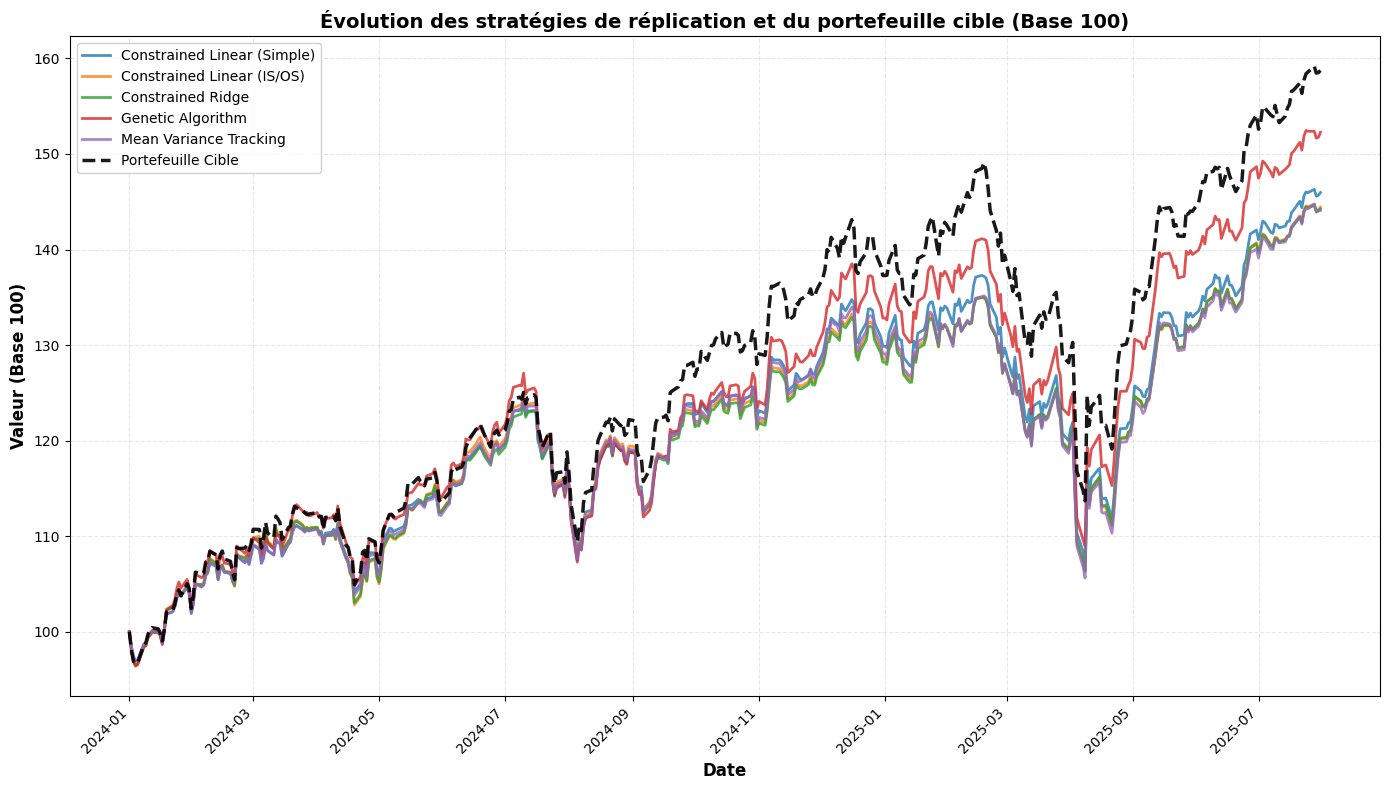

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Créer le graphique des évolutions en base 100
plt.figure(figsize=(14, 8))

# Tracer chaque stratégie
plt.plot(evolution_base100['date'], evolution_base100['base100_w1'], 
         label='Constrained Linear (Simple)', linewidth=2, alpha=0.8)
plt.plot(evolution_base100['date'], evolution_base100['base100_w2'], 
         label='Constrained Linear (IS/OS)', linewidth=2, alpha=0.8)
plt.plot(evolution_base100['date'], evolution_base100['base100_w3'], 
         label='Constrained Ridge', linewidth=2, alpha=0.8)
plt.plot(evolution_base100['date'], evolution_base100['base100_w4'], 
         label='Genetic Algorithm', linewidth=2, alpha=0.8)
plt.plot(evolution_base100['date'], evolution_base100['base100_w5'], 
         label='Mean Variance Tracking', linewidth=2, alpha=0.8)

# Tracer le portefeuille cible (en gras ou avec un style différent pour le distinguer)
plt.plot(evolution_base100['date'], evolution_base100['base100_cible'], 
         label='Portefeuille Cible', linewidth=2.5, linestyle='--', 
         color='black', alpha=0.9)

# Configuration du graphique
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Valeur (Base 100)', fontsize=12, fontweight='bold')
plt.title('Évolution des stratégies de réplication et du portefeuille cible (Digital Economy Index)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

# Format de l'axe des dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45, ha='right')

# Ajuster la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()

# Optionnel : Sauvegarder le graphique
# plt.savefig('results/figures/evolution_base100_strategies.png', dpi=300, bbox_inches='tight')

## 3. Comparaison des poids moyens par méthode et secteur

In [26]:
# Construction du dataframe des poids moyens par méthode et secteur

# Récupérer les noms des secteurs (colonnes de sector_df sauf 'date')
sector_names = [col for col in sector_df_daily.columns if col != 'date']

# Calculer les poids moyens pour chaque méthode
# w1 est déjà un vecteur simple
w1_mean = w1

# w2, w3, w4, w5 sont des listes de vecteurs, on calcule la moyenne
w2_mean = np.mean(np.array(w2), axis=0) if isinstance(w2, list) else w2
w3_mean = np.mean(np.array(w3), axis=0) if isinstance(w3, list) else w3
w4_mean = np.mean(np.array(w4), axis=0) if isinstance(w4, list) else w4
w5_mean = np.mean(np.array(w5), axis=0) if isinstance(w5, list) else w5

# Créer le dataframe
weights_df = pd.DataFrame({
    'Constrained Linear (Simple)': w1_mean,
    'Constrained Linear (IS/OS)': w2_mean,
    'Constrained Ridge': w3_mean,
    'Genetic Algorithm': w4_mean,
    'Mean Variance Tracking': w5_mean
}, index=sector_names)

# Afficher le dataframe
print("Poids moyens par méthode et secteur :")
print(weights_df)
print("\nSomme des poids par méthode (doit être proche de 1) :")
print(weights_df.sum())


Poids moyens par méthode et secteur :
                                            Constrained Linear (Simple)  \
MSCI ACWI IMI Consumer Discretionary Index                 2.122164e-01   
MSCI ACWI IMI Consumer Staples Index                       3.695455e-23   
MSCI ACWI IMI Energy Index                                 1.629035e-24   
MSCI ACWI IMI Financials Index                             2.345507e-23   
MSCI ACWI IMI Healthcare Index                            -2.365181e-24   
MSCI ACWI IMI Industrials Index                            2.435419e-23   
MSCI ACWI IMI Information Technology Index                 4.469866e-01   
MSCI ACWI IMI Materials Index                              3.327960e-23   
MSCI ACWI IMI Real Estate Index                            4.924616e-23   
MSCI ACWI IMI Communication Services Index                 3.407970e-01   
MSCI ACWI IMI Utilities Index                              5.650538e-24   

                                            Constrained Linea

<Figure size 1400x600 with 0 Axes>

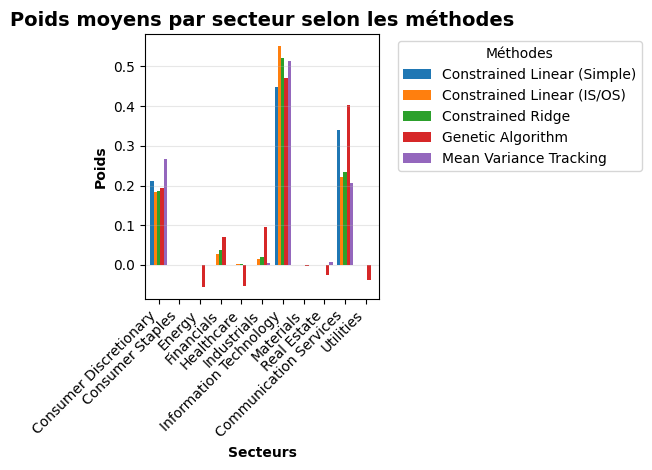

In [27]:
# Visualisation des poids par secteur selon les méthodes (Barres groupées)

import matplotlib.pyplot as plt
import re

# Extraire uniquement la partie entre "IMI" et "Index" des noms de secteurs
def extract_sector_name(full_name):
    """Extrait la partie entre 'IMI' et 'Index' du nom complet"""
    match = re.search(r'IMI\s+(.+?)\s+Index', full_name)
    if match:
        return match.group(1)
    return full_name

# Créer les labels simplifiés pour l'axe X
sector_labels = [extract_sector_name(sector) for sector in weights_df.index]

plt.figure(figsize=(14, 6))
ax = weights_df.plot(kind='bar', width=0.8)
plt.title('Poids moyens par secteur selon les méthodes', fontsize=14, fontweight='bold')
plt.xlabel('Secteurs', fontweight='bold')
plt.ylabel('Poids', fontweight='bold')
plt.legend(title='Méthodes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
ax.set_xticklabels(sector_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()
